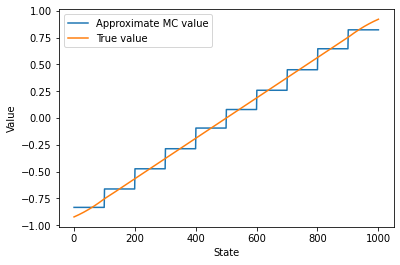

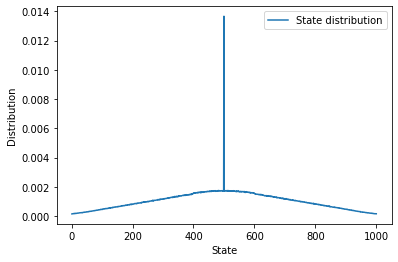

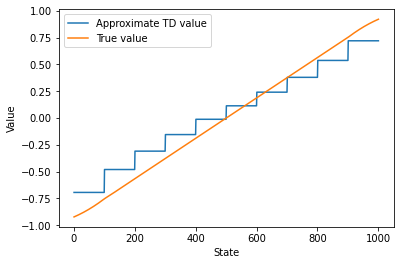

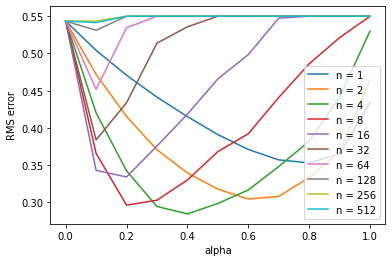

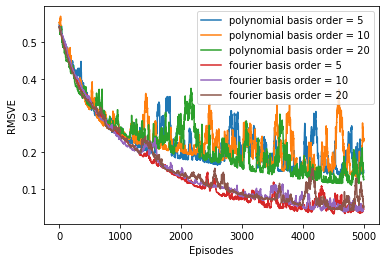

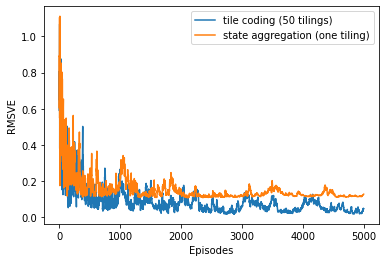

In [1]:


from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# # of states except for terminal states
N_STATES = 1000

# true state values, just a promising guess
trueStateValues = np.arange(-1001, 1003, 2) / 1001.0

# all states
states = np.arange(1, N_STATES + 1)

# start from a central state
START_STATE = 500

# terminal states
END_STATES = [0, N_STATES + 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]

# maximum stride for an action
STEP_RANGE = 100

# Dynamic programming to find the true state values, based on the promising guess above
# Assume all rewards are 0, given that we have already given value -1 and 1 to terminal states
while True:
    oldTrueStateValues = np.copy(trueStateValues)
    for state in states:
        trueStateValues[state] = 0
        for action in ACTIONS:
            for step in range(1, STEP_RANGE + 1):
                step *= action
                newState = state + step
                newState = max(min(newState, N_STATES + 1), 0)
                # asynchronous update for faster convergence
                trueStateValues[state] += 1.0 / (2 * STEP_RANGE) * trueStateValues[newState]
    error = np.sum(np.abs(oldTrueStateValues - trueStateValues))
    #print(error)
    if error < 1e-2:
        break
# correct the state value for terminal states to 0
trueStateValues[0] = trueStateValues[-1] = 0

# take an @action at @state, return new state and reward for this transition
def takeAction(state, action):
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES + 1), 0)
    if state == 0:
        reward = -1
    elif state == N_STATES + 1:
        reward = 1
    else:
        reward = 0
    return state, reward

# get an action, following random policy
def getAction():
    if np.random.binomial(1, 0.5) == 1:
        return 1
    return -1

# a wrapper class for aggregation value function
class ValueFunction:
    # @numOfGroups: # of aggregations
    def __init__(self, numOfGroups):
        self.numOfGroups = numOfGroups
        self.groupSize = N_STATES // numOfGroups

        # thetas
        self.params = np.zeros(numOfGroups)

    # get the value of @state
    def value(self, state):
        if state in END_STATES:
            return 0
        groupIndex = (state - 1) // self.groupSize
        return self.params[groupIndex]

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):
        groupIndex = (state - 1) // self.groupSize
        self.params[groupIndex] += delta

# a wrapper class for tile coding value function
class TilingsValueFunction:
    # @numOfTilings: # of tilings
    # @tileWidth: each tiling has several tiles, this parameter specifies the width of each tile
    # @tilingOffset: specifies how tilings are put together
    def __init__(self, numOfTilings, tileWidth, tilingOffset):
        self.numOfTilings = numOfTilings
        self.tileWidth = tileWidth
        self.tilingOffset = tilingOffset

        # To make sure that each sate is covered by same number of tiles,
        # we need one more tile for each tiling
        self.tilingSize = N_STATES // tileWidth + 1

        # weight for each tile
        self.params = np.zeros((self.numOfTilings, self.tilingSize))

        # For performance, only track the starting position for each tiling
        # As we have one more tile for each tiling, the starting position will be negative
        self.tilings = np.arange(-tileWidth + 1, 0, tilingOffset)

    # get the value of @state
    def value(self, state):
        stateValue = 0.0
        # go through all the tilings
        for tilingIndex in range(0, len(self.tilings)):
            # find the active tile in current tiling
            tileIndex = (state - self.tilings[tilingIndex]) // self.tileWidth
            stateValue += self.params[tilingIndex, tileIndex]
        return stateValue

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):

        # each state is covered by same number of tilings
        # so the delta should be divided equally into each tiling (tile)
        delta /= self.numOfTilings

        # go through all the tilings
        for tilingIndex in range(0, len(self.tilings)):
            # find the active tile in current tiling
            tileIndex = (state - self.tilings[tilingIndex]) // self.tileWidth
            self.params[tilingIndex, tileIndex] += delta

# a wrapper class for polynomial / Fourier -based value function
POLYNOMIAL_BASES = 0
FOURIER_BASES = 1
class BasesValueFunction:
    # @order: # of bases, each function also has one more constant parameter (called bias in machine learning)
    # @type: polynomial bases or Fourier bases
    def __init__(self, order, type):
        self.order = order
        self.weights = np.zeros(order + 1)

        # set up bases function
        self.bases = []
        if type == POLYNOMIAL_BASES:
            for i in range(0, order + 1):
                self.bases.append(lambda s, i=i: pow(s, i))
        elif type == FOURIER_BASES:
            for i in range(0, order + 1):
                self.bases.append(lambda s, i=i: np.cos(i * np.pi * s))

    # get the value of @state
    def value(self, state):
        # map the state space into [0, 1]
        state /= float(N_STATES)
        # get the feature vector
        feature = np.asarray([func(state) for func in self.bases])
        return np.dot(self.weights, feature)

    def update(self, delta, state):
        # map the state space into [0, 1]
        state /= float(N_STATES)
        # get derivative value
        derivativeValue = np.asarray([func(state) for func in self.bases])
        self.weights += delta * derivativeValue

# gradient Monte Carlo algorithm
# @valueFunction: an instance of class ValueFunction
# @alpha: step size
# @distribution: array to store the distribution statistics
def gradientMonteCarlo(valueFunction, alpha, distribution=None):
    currentState = START_STATE
    trajectory = [currentState]

    # We assume gamma = 1, so return is just the same as the latest reward
    reward = 0.0
    while currentState not in END_STATES:
        action = getAction()
        newState, reward = takeAction(currentState, action)
        trajectory.append(newState)
        currentState = newState

    # Gradient update for each state in this trajectory
    for state in trajectory[:-1]:
        delta = alpha * (reward - valueFunction.value(state))
        valueFunction.update(delta, state)
        if distribution is not None:
            distribution[state] += 1

# semi-gradient n-step TD algorithm
# @valueFunction: an instance of class ValueFunction
# @n: # of steps
# @alpha: step size
def semiGradientTemporalDifference(valueFunction, n, alpha):
    # initial starting state
    currentState = START_STATE

    # arrays to store states and rewards for an episode
    # space isn't a major consideration, so I didn't use the mod trick
    states = [currentState]
    rewards = [0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # choose an action randomly
            action = getAction()
            newState, reward = takeAction(currentState, action)

            # store new state and new reward
            states.append(newState)
            rewards.append(reward)

            if newState in END_STATES:
                T = time

        # get the time of the state to update
        updateTime = time - n
        if updateTime >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(updateTime + 1, min(T, updateTime + n) + 1):
                returns += rewards[t]
            # add state value to the return
            if updateTime + n <= T:
                returns += valueFunction.value(states[updateTime + n])
            stateToUpdate = states[updateTime]
            # update the value function
            if not stateToUpdate in END_STATES:
                delta = alpha * (returns - valueFunction.value(stateToUpdate))
                valueFunction.update(delta, stateToUpdate)
        if updateTime == T - 1:
            break
        currentState = newState

# Figure 9.1, gradient Monte Carlo algorithm
def figure9_1():
    nEpisodes = int(1e5)
    alpha = 2e-5

    # we have 10 aggregations in this example, each has 100 states
    valueFunction = ValueFunction(10)
    distribution = np.zeros(N_STATES + 2)
    for episode in range(0, nEpisodes):
        #print('episode:', episode)
        gradientMonteCarlo(valueFunction, alpha, distribution)

    distribution /= np.sum(distribution)
    stateValues = [valueFunction.value(i) for i in states]

    plt.figure(0)
    plt.plot(states, stateValues, label='Approximate MC value')
    plt.plot(states, trueStateValues[1: -1], label='True value')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.legend()

    plt.figure(1)
    plt.plot(states, distribution[1: -1], label='State distribution')
    plt.xlabel('State')
    plt.ylabel('Distribution')
    plt.legend()

# semi-gradient TD on 1000-state random walk
def figure9_2Left():
    nEpisodes = int(1e5)
    alpha = 2e-4
    valueFunction = ValueFunction(10)
    for episode in range(0, nEpisodes):
        #print('episode:', episode)
        semiGradientTemporalDifference(valueFunction, 1, alpha)

    stateValues = [valueFunction.value(i) for i in states]
    plt.figure(2)
    plt.plot(states, stateValues, label='Approximate TD value')
    plt.plot(states, trueStateValues[1: -1], label='True value')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.legend()

# different alphas and steps for semi-gradient TD
def figure9_2Right():
    # truncate value for better display
    truncateValue = 0.55

    # all possible steps
    steps = np.power(2, np.arange(0, 10))

    # all possible alphas
    alphas = np.arange(0, 1.1, 0.1)

    # each run has 10 episodes
    episodes = 10

    # perform 100 independent runs
    runs = 100

    # track the errors for each (step, alpha) combination
    errors = np.zeros((len(steps), len(alphas)))
    for run in range(0, runs):
        for stepInd, step in zip(range(len(steps)), steps):
            for alphaInd, alpha in zip(range(len(alphas)), alphas):
                #print('run:', run, 'step:', step, 'alpha:', alpha)
                # we have 20 aggregations in this example
                valueFunction = ValueFunction(20)
                for ep in range(0, episodes):
                    semiGradientTemporalDifference(valueFunction, step, alpha)
                    # calculate the RMS error
                    currentStateValues = np.asarray([valueFunction.value(i) for i in states])
                    errors[stepInd, alphaInd] += np.sqrt(np.sum(np.power(currentStateValues - trueStateValues[1: -1], 2)) / N_STATES)
    # take average
    errors /= episodes * runs
    # truncate the error
    errors[errors > truncateValue] = truncateValue
    plt.figure(3)
    for i in range(0, len(steps)):
        plt.plot(alphas, errors[i, :], label='n = ' + str(steps[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.legend()

# Figure 9.2, it will take quite a while
def figure9_2():
    figure9_2Left()
    figure9_2Right()

# Figure 9.5, Fourier basis and polynomials
def figure9_5():
    # my machine can only afford 1 run
    runs = 1

    episodes = 5000

    # # of bases
    orders = [5, 10, 20]

    alphas = [1e-4, 5e-5]
    labels = [['polynomial basis'] * 3, ['fourier basis'] * 3]

    # track errors for each episode
    errors = np.zeros((len(alphas), len(orders), episodes))
    for run in range(0, runs):
        for i in range(0, len(orders)):
            valueFunctions = [BasesValueFunction(orders[i], POLYNOMIAL_BASES), BasesValueFunction(orders[i], FOURIER_BASES)]
            for j in range(0, len(valueFunctions)):
                for episode in range(0, episodes):
                    #print('run:', run, 'order:', orders[i], labels[j][i], 'episode:', episode)

                    # gradient Monte Carlo algorithm
                    gradientMonteCarlo(valueFunctions[j], alphas[j])

                    # get state values under current value function
                    stateValues = [valueFunctions[j].value(state) for state in states]

                    # get the root-mean-squared error
                    errors[j, i, episode] += np.sqrt(np.mean(np.power(trueStateValues[1: -1] - stateValues, 2)))

    # average over independent runs
    errors /= runs

    plt.figure(5)
    for i in range(0, len(alphas)):
        for j in range(0, len(orders)):
            plt.plot(errors[i, j, :], label=labels[i][j]+' order = ' + str(orders[j]))
    plt.xlabel('Episodes')
    plt.ylabel('RMSVE')
    plt.legend()

# Figure 9.10, it will take quite a while
def figure9_10():

    # My machine can only afford one run, thus the curve isn't so smooth
    runs = 1

    # number of episodes
    episodes = 5000

    numOfTilings = 50

    # each tile will cover 200 states
    tileWidth = 200

    # how to put so many tilings
    tilingOffset = 4

    labels = ['tile coding (50 tilings)', 'state aggregation (one tiling)']

    # track errors for each episode
    errors = np.zeros((len(labels), episodes))
    for run in range(0, runs):
        # initialize value functions for multiple tilings and single tiling
        valueFunctions = [TilingsValueFunction(numOfTilings, tileWidth, tilingOffset),
                         ValueFunction(N_STATES // tileWidth)]
        for i in range(0, len(valueFunctions)):
            for episode in range(0, episodes):
                #print('run:', run, 'episode:', episode)

                # I use a changing alpha according to the episode instead of a small fixed alpha
                # With a small fixed alpha, I don't think 5000 episodes is enough for so many
                # parameters in multiple tilings.
                # The asymptotic performance for single tiling stays unchanged under a changing alpha,
                # however the asymptotic performance for multiple tilings improves significantly
                alpha = 1.0 / (episode + 1)

                # gradient Monte Carlo algorithm
                gradientMonteCarlo(valueFunctions[i], alpha)

                # get state values under current value function
                stateValues = [valueFunctions[i].value(state) for state in states]

                # get the root-mean-squared error
                errors[i][episode] += np.sqrt(np.mean(np.power(trueStateValues[1: -1] - stateValues, 2)))

    # average over independent runs
    errors /= runs

    plt.figure(4)
    for i in range(0, len(labels)):
        plt.plot(errors[i], label=labels[i])
    plt.xlabel('Episodes')
    plt.ylabel('RMSVE')
    plt.legend()

figure9_1()
figure9_2()
figure9_5()
figure9_10()
plt.show()